In [387]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna import create_study
from optuna.integration import XGBoostPruningCallback
pd.set_option("display.max_rows", 100)

In [397]:
data = pd.read_csv("../data/processed/data_outliers_treated_v2.csv")
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


In [398]:
def preprocess_data(data):
    df_grouped = data.groupby(data.columns.tolist()[:-1], as_index = False).agg({'Sourcing Cost': ['mean']})
    df_grouped.columns = ["_".join(x).rstrip("_") for x in df_grouped.columns.ravel()]
    df_grouped['Month of Sourcing'] = df_grouped['Month of Sourcing'].apply(lambda x: datetime.strptime("01-" + x, '%d-%b-%y')) 
    df_grouped.columns = [column.replace(" ", "_") for column in df_grouped.columns]
    return df_grouped

In [399]:
df_processed = preprocess_data(data)
df_processed.head()

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-04-01,93.266935
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-08-01,99.687042
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-12-01,109.121740
3,NTM1,X1,A1,DIRECT,Small,Powder,2021-02-01,98.773374
4,NTM1,X1,A1,DIRECT,Small,Powder,2021-01-01,98.160315


In [107]:
#looking at the high values

In [108]:
val1 = df_processed.groupby(['Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 'Product_Type'])['Sourcing_Cost_mean'].mean().tolist()

In [109]:
val2  = df_processed.groupby(['Manufacturer', 'Area_Code', 'Product_Size', 'Product_Type'])['Sourcing_Cost_mean'].mean().tolist()

In [110]:
val3 = df_processed.groupby(['Manufacturer', 'Product_Type'])['Sourcing_Cost_mean'].mean().tolist()

In [111]:
df_ = pd.DataFrame()
df_['val1'] = val1
df_['val2'] = val2 + [0, 0, 0, 0]

In [112]:
import seaborn as sns

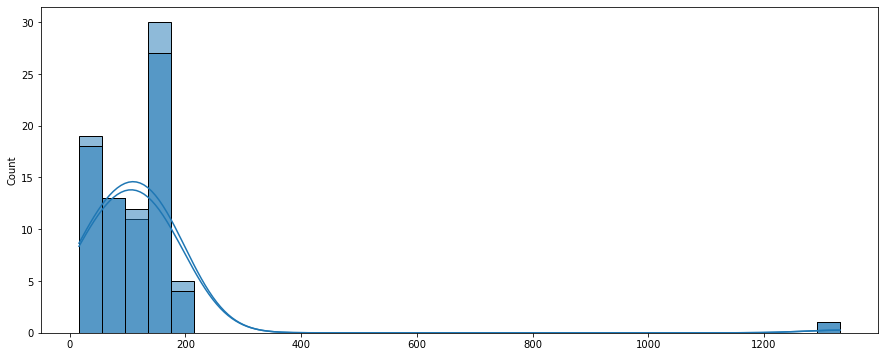

In [113]:
plt.figure(figsize = (15, 6))
l1 = sns.histplot(val1, kde = True)
sns.histplot(val2, kde = True)
# l2 = sns.histplot(val3, kde = True)
plt.show()


In [255]:
df_processed.drop(columns = ['Sourcing_Channel'], inplace = True)

### Encoding the Columns

For column: Product Size: Perform Label Encoding as it is an Ordinal Column <br>
For column: ProductType, Manufacturer and Product_Type: Perform OHE as these are Nominal and have lesser categories. <br>
For column: Area Code: Perform Hash/Binary Encoding

In [69]:
import category_encoders as ce

In [256]:
encoder1= ce.OrdinalEncoder(cols=['Product_Size'],return_df=True,
                           mapping=[{'col':'Product_Size',
'mapping':{'Small': 1, 'Large': 2, 'ExtraLarge': 3}}])
df_encoded = encoder1.fit_transform(df_processed)

C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [257]:
df_encoded = pd.get_dummies(df_encoded, columns = ['ProductType', 'Manufacturer', 'Product_Type'], drop_first = True)
df_encoded.head()

,Area_Code,Product_Size,Month_of_Sourcing,Sourcing_Cost_mean,ProductType_NTM2,ProductType_NTM3,Manufacturer_X2,Manufacturer_X3,Product_Type_Powder
0,A1,1,2021-04-01,92.813339,0,0,0,0,1
1,A1,1,2020-08-01,94.795753,0,0,0,0,1
2,A1,1,2020-12-01,106.372132,0,0,0,0,1
3,A1,1,2021-02-01,93.484534,0,0,0,0,1
4,A1,1,2021-01-01,91.816050,0,0,0,0,1


In [258]:
encoder3 =ce.HashingEncoder(cols='Area_Code',n_components=15)
df_encoded = encoder3.fit_transform(df_encoded)

In [118]:
df_encoded.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_13,col_14,Product_Size,Month_of_Sourcing,Sourcing_Cost_mean,ProductType_NTM2,ProductType_NTM3,Manufacturer_X2,Manufacturer_X3,Product_Type_Powder
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,2021-04-01,92.813339,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,2020-08-01,94.795753,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,2020-12-01,106.372132,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,2021-02-01,93.484534,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,2021-01-01,91.816050,0,0,0,0,1


In [82]:
df_encoded['Month_of_Sourcing'] = df_encoded['Month_of_Sourcing'].dt.month 

In [83]:
x_train, x_test, y_train, y_test = train_test_split(df_encoded.drop(columns = ['Sourcing_Cost_mean']),
                                                   df_encoded[['Sourcing_Cost_mean']], test_size = 0.3, 
                                                   shuffle = True, random_state = 70)

In [84]:
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)


In [85]:
df_final = pd.DataFrame()
df_final['y_test']  = y_test['Sourcing_Cost_mean']
df_final['y_pred'] = y_pred
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,y_test,y_pred
0,141.779010,141.334213
1,133.300000,132.893661
2,18.765257,56.195007
3,42.996422,69.586624
4,264.960000,79.615326


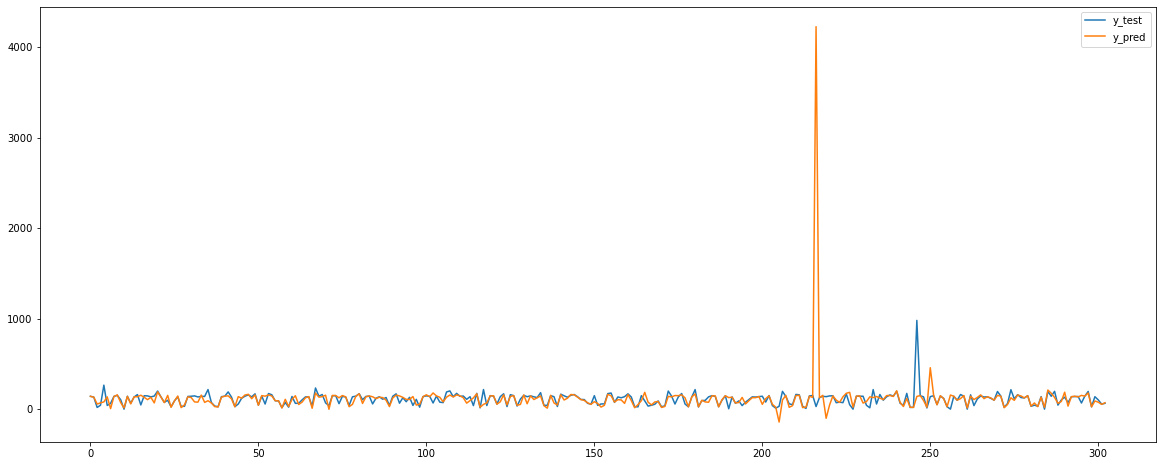

In [86]:
df_final.plot(figsize = (20, 8))
plt.show()

### Testing Against Given TestData

In [87]:
df_test = pd.read_csv("../data/raw/DS_ML Coding Challenge Dataset - Test Dataset.csv")
df_processed = preprocess_data(df_test)
df_processed.drop(columns = ['Sourcing_Channel'], inplace = True)


,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,Jun-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,Jun-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,Jun-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,Jun-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,Jun-21,169.42


In [90]:
df_processed = preprocess_data(df_test)
df_processed.head()

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-06-01,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,2021-06-01,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,2021-06-01,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,2021-06-01,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,2021-06-01,169.42


In [92]:
df_processed.drop(columns = ['Sourcing_Channel'], inplace = True)

In [93]:
df_encoded = encoder1.transform(df_processed)

In [95]:
df_encoded = pd.get_dummies(df_encoded, columns = ['ProductType', 'Manufacturer', 'Product_Type'], drop_first = True)
df_encoded.head()

,Area_Code,Product_Size,Month_of_Sourcing,Sourcing_Cost_mean,ProductType_NTM2,ProductType_NTM3,Manufacturer_X2,Manufacturer_X3,Product_Type_Powder
0,A1,1,2021-06-01,103.68,0,0,0,0,1
1,A10,2,2021-06-01,155.75,0,0,0,0,1
2,A10,2,2021-06-01,143.02,0,0,0,0,1
3,A11,2,2021-06-01,139.39,0,0,0,0,1
4,A2,2,2021-06-01,169.42,0,0,0,0,1


In [96]:
df_encoded = encoder3.transform(df_encoded)

In [97]:
df_encoded['Month_of_Sourcing'] = df_encoded['Month_of_Sourcing'].dt.month 

In [98]:
X_t = df_encoded.drop(columns = ['Sourcing_Cost_mean'])

In [99]:
y_pred = model.predict(X_t)

In [100]:
df_final = pd.DataFrame()
df_final['y_test']  = df_processed['Sourcing_Cost_mean']
df_final['y_pred'] = y_pred
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,y_test,y_pred
0,103.68,104.392143
1,155.75,133.029755
2,143.02,133.029755
3,139.39,134.452621
4,169.42,143.691132


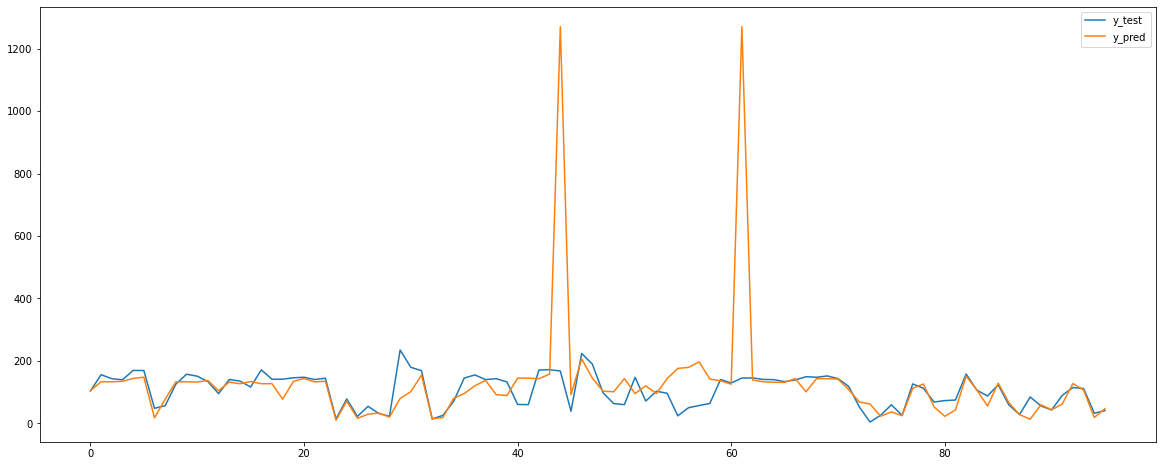

In [101]:
df_final.plot(figsize = (20, 8))
plt.show()

### Lag Based Approach

In [400]:
df_ = df_processed.copy()
df_.head()

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-04-01,93.266935
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-08-01,99.687042
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-12-01,109.121740
3,NTM1,X1,A1,DIRECT,Small,Powder,2021-02-01,98.773374
4,NTM1,X1,A1,DIRECT,Small,Powder,2021-01-01,98.160315


In [401]:
df_.shape

(1020, 8)

In [402]:
lag1_vals = df_.groupby(by = df_.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(1)
lag2_vals = df_.groupby(by = df_.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(2)
lag3_vals = df_.groupby(by = df_.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(3)

In [403]:
df_['Sourcing_Cost_lag1'] = lag1_vals['Sourcing_Cost_mean'].values
df_['Sourcing_Cost_lag2'] = lag2_vals['Sourcing_Cost_mean'].values
df_['Sourcing_Cost_lag3'] = lag3_vals['Sourcing_Cost_mean'].values

In [404]:
df_.dropna(inplace = True,axis = 'rows')

In [405]:
df_.drop(columns = ['Month_of_Sourcing'], inplace = True)

In [412]:
df_lag_encoded = pd.get_dummies(df_, columns = ['ProductType', 'Manufacturer', 'Product_Type', 'Sourcing_Channel'], drop_first = True)

In [413]:
x_train, x_test, y_train, y_test = train_test_split(df_lag_encoded.drop(columns = ['Sourcing_Cost_mean']),
                                                   df_lag_encoded[['Sourcing_Cost_mean']], test_size = 0.3, 
                                                   shuffle = True, random_state = 10)

In [414]:
x_train_encoded = encoder1.fit_transform(x_train)
x_train_encoded = encoder3.fit_transform(x_train_encoded)

In [415]:
x_test_encoded = encoder1.transform(x_test)
x_test_encoded = encoder3.transform(x_test_encoded)

In [416]:
model = XGBRegressor()

In [417]:
model.fit(x_train_encoded, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [418]:
y_pred_encoded = model.predict(x_test_encoded)

In [419]:
df_final = pd.DataFrame()
df_final['y_test']  = y_test['Sourcing_Cost_mean']
df_final['y_pred'] = y_pred_encoded
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,y_test,y_pred
0,12.385302,52.500942
1,106.269060,110.469856
2,35.007922,23.720280
3,114.930839,143.240479
4,209.744281,191.222000


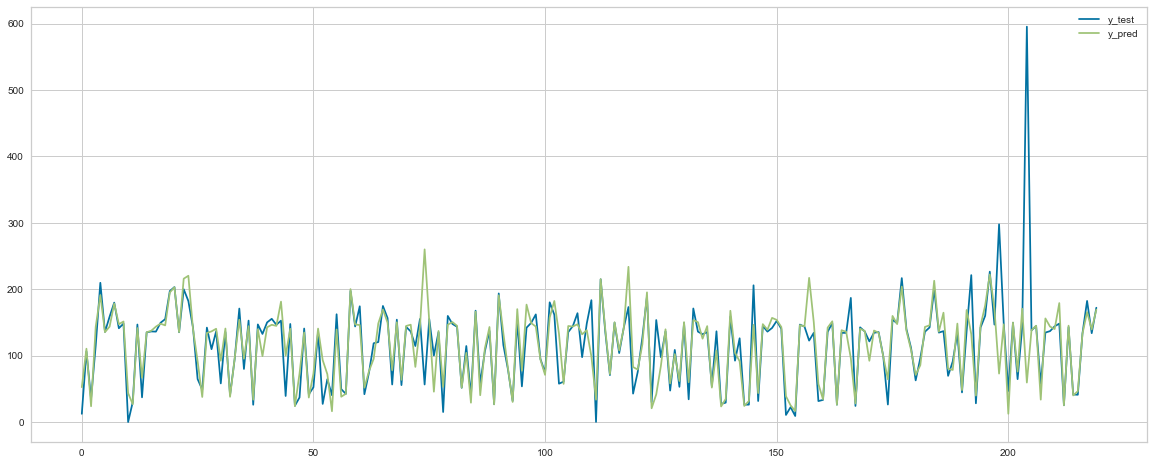

In [420]:
df_final.plot(figsize = (20, 8))
plt.show()

In [421]:
print(f"Mean Absolute Error: {mean_absolute_error(df_final['y_test'], df_final['y_pred'])}")
print(f"Roto Mean Squared Error: {np.sqrt(mean_squared_error(df_final['y_test'], df_final['y_pred']))}")

Mean Absolute Error: 18.276622375141393
Roto Mean Squared Error: 47.491669014304115


### Train Model on Entire Data

## Testing Against Given Test Data

In [422]:
df_test = pd.read_csv("../data/raw/DS_ML Coding Challenge Dataset - Test Dataset.csv")
df_test_processed = preprocess_data(df_test)
# df_test_processed.drop(columns = ['Sourcing_Channel'], inplace = True)
df_test_processed.head()

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-06-01,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,2021-06-01,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,2021-06-01,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,2021-06-01,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,2021-06-01,169.42


In [423]:
df_test_processed.shape

(96, 8)

In [424]:
X_test_processed = df_test_processed.drop(['Sourcing_Cost_mean'], axis = 1)
y_test_final = df_test_processed['Sourcing_Cost_mean']

In [425]:
X_test_processed['Sourcing_Cost_mean'] = 0

In [426]:
# df_processed.drop(columns = ['Sourcing_Channel'], inplace = True)

In [427]:
df_concat = pd.concat([df_processed, X_test_processed], axis = 'rows', ignore_index = True)
df_concat.head()

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-04-01,93.266935
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-08-01,99.687042
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-12-01,109.121740
3,NTM1,X1,A1,DIRECT,Small,Powder,2021-02-01,98.773374
4,NTM1,X1,A1,DIRECT,Small,Powder,2021-01-01,98.160315


In [428]:
df_processed

,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-04-01,93.266935
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-08-01,99.687042
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-12-01,109.121740
3,NTM1,X1,A1,DIRECT,Small,Powder,2021-02-01,98.773374
4,NTM1,X1,A1,DIRECT,Small,Powder,2021-01-01,98.160315
...,...,...,...,...,...,...,...,...
1015,NTM3,X3,A22,RETAIL,Large,Powder,2021-03-01,51.526898
1016,NTM3,X3,A22,RETAIL,Large,Powder,2021-05-01,50.464128
1017,NTM3,X3,A22,RETAIL,Large,Powder,2020-11-01,54.019449
1018,NTM3,X3,A22,RETAIL,Large,Powder,2020-10-01,44.609049


In [211]:
df_concat.groupby(df_concat.columns.tolist()[:-1], as_index = False).agg({'Sourcing_Cost_mean': ['count']})

,ProductType,Manufacturer,Area_Code,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
,,,,,,,count
0,NTM1,X1,A1,Small,Powder,2020-07-01,1
1,NTM1,X1,A1,Small,Powder,2020-08-01,1
2,NTM1,X1,A1,Small,Powder,2020-09-01,1
3,NTM1,X1,A1,Small,Powder,2020-10-01,1
4,NTM1,X1,A1,Small,Powder,2020-11-01,1
...,...,...,...,...,...,...,...
1067,NTM3,X3,A22,Large,Powder,2021-02-01,1
1068,NTM3,X3,A22,Large,Powder,2021-03-01,1
1069,NTM3,X3,A22,Large,Powder,2021-04-01,1


In [429]:
df_test_grouped = df_concat.groupby(df_concat.columns.tolist()[:-1], as_index = False)['Sourcing_Cost_mean'].mean()

In [430]:
X_test_processed.shape

(96, 8)

In [431]:
df_test_grouped.shape

(1116, 8)

In [432]:
1007+93

1100

In [433]:
lag1_vals = df_test_grouped.groupby(by = df_test_grouped.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(1)
lag2_vals = df_test_grouped.groupby(by = df_test_grouped.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(2)
lag3_vals = df_test_grouped.groupby(by = df_test_grouped.columns.tolist()[:-2], as_index = False)['Sourcing_Cost_mean'].shift(3)

In [434]:
df_test_grouped['Sourcing_Cost_lag1'] = lag1_vals['Sourcing_Cost_mean'].values
df_test_grouped['Sourcing_Cost_lag2'] = lag2_vals['Sourcing_Cost_mean'].values
df_test_grouped['Sourcing_Cost_lag3'] = lag3_vals['Sourcing_Cost_mean'].values

In [435]:
X_test_lag = df_test_grouped[df_test_grouped['Month_of_Sourcing'] == '2021-06-01'].drop(['Sourcing_Cost_mean'], axis = 1)

In [436]:
X_test_lag.reset_index(inplace = True, drop = True)
X_test_lag.shape

(96, 10)

In [437]:
X_test_lag.drop(['Month_of_Sourcing', 'Sourcing_Channel'], 1, inplace = True)

In [438]:
X_test_lag_encoded = pd.get_dummies(X_test_lag, columns = ['ProductType', 'Manufacturer', 'Product_Type'], drop_first = True)

In [440]:
X_test_lag_encoded = encoder1.transform(X_test_lag_encoded)
X_test_lag_encoded = encoder3.transform(X_test_lag_encoded)

C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [441]:
y_pred_final = model.predict(X_test_lag_encoded)

ValueError: feature_names mismatch: ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'Product_Size', 'Sourcing_Cost_lag1', 'Sourcing_Cost_lag2', 'Sourcing_Cost_lag3', 'ProductType_NTM2', 'ProductType_NTM3', 'Manufacturer_X2', 'Manufacturer_X3', 'Product_Type_Powder', 'Sourcing_Channel_ECOM', 'Sourcing_Channel_RETAIL', 'Sourcing_Channel_WHOLESALE'] ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'Product_Size', 'Sourcing_Cost_lag1', 'Sourcing_Cost_lag2', 'Sourcing_Cost_lag3', 'ProductType_NTM2', 'ProductType_NTM3', 'Manufacturer_X2', 'Manufacturer_X3', 'Product_Type_Powder']
expected Sourcing_Channel_RETAIL, Sourcing_Channel_ECOM, Sourcing_Channel_WHOLESALE in input data

In [ ]:
df_final = pd.DataFrame()
df_final['y_test']  = y_test_final
df_final['y_pred'] = y_pred_final
df_final.reset_index(inplace = True, drop = True)
df_final.head()

In [ ]:
df_final.plot(figsize = (20, 8))
plt.show()

In [242]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error


Prediction Error Plot


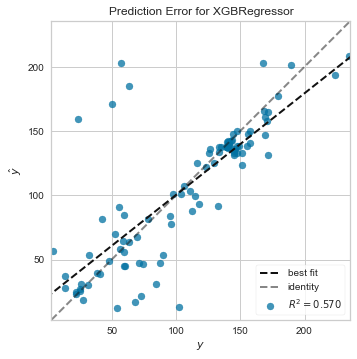

C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                model=None)

Residuals Plot


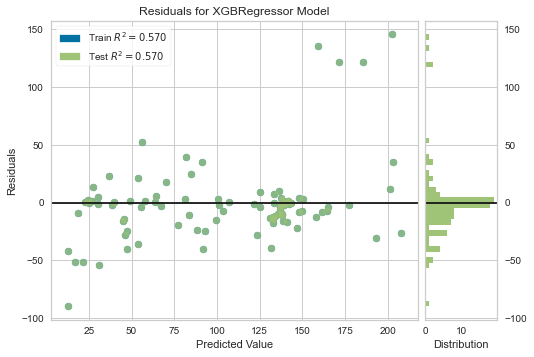

ResidualsPlot(ax=<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
              line_color=None, model=None, test_alpha=None, test_color=None,
              train_alpha=None, train_color=None)


C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [249]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(model, X_test_lag_encoded, y_test_final))

# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(model, X_test_lag_encoded, y_test_final))

In [234]:
print(f"Mean Absolute Error: {mean_absolute_error(df_final['y_test'], df_final['y_pred'])}")
print(f"Roto Mean Squared Error: {np.sqrt(mean_squared_error(df_final['y_test'], df_final['y_pred']))}")

Mean Absolute Error: 19.112148706118266
Roto Mean Squared Error: 34.13677984586774


<Figure size 1080x432 with 0 Axes>

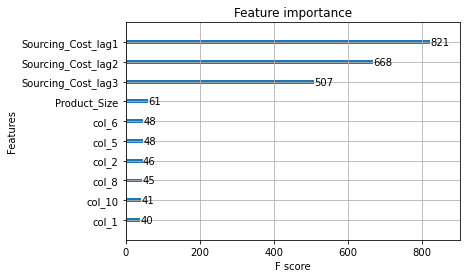

In [240]:
plt.figure(figsize = (15, 6))
ax = xgb.plot_importance(model, max_num_features = 10, importance_type = 'weight')
plt.show()

## Fine Tuning

For Fine Tuning, we will be using the entire training data

In [352]:
df_lag_encoded = encoder1.fit_transform(df_lag_encoded)
df_lag_encoded = encoder3.fit_transform(df_lag_encoded)

C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [353]:
X = df_lag_encoded.drop(['Sourcing_Cost_mean'], 1)
y = df_lag_encoded['Sourcing_Cost_mean']

In [355]:
def objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=20,
):
    # XGBoost parameters
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
    }

    model = XGBRegressor(**params)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X
    y_values = y
    return cross_val_score(model, X_values, y_values, cv=5).mean()

In [356]:
from sklearn.model_selection import cross_val_score

In [357]:
FS = (14, 6)  # figure size
RS = 124  # random state
N_JOBS = 8  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# Optuna
N_TRIALS = 100
MULTIVARIATE = True

# XGBoost
EARLY_STOPPING_ROUNDS = 30

In [358]:
sampler = TPESampler(seed=RS, multivariate=MULTIVARIATE)
study = create_study(direction="minimize", sampler=sampler)
study.optimize(
    lambda trial: objective(
        trial,
        np.array(X),
        np.array(y),
        random_state=RS,
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        n_jobs=1,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    ),
    n_trials=N_TRIALS,
    n_jobs=1,
)

# display params
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

C:\Users\ndh00560\AppData\Local\Continuum\anaconda3\envs\neuralprophet\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

[I 2021-07-24 17:53:36,138] A new study created in memory with name: no-name-d9f4b13e-bd12-4d05-92f4-a682ecb88f11
[I 2021-07-24 17:53:36,653] Trial 0 finished with value: 0.3976008448582367 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.018675986054482886, 'colsample_bytree': 0.3308770188910249, 'subsample': 0.522237444587806, 'alpha': 0.06636940416485738, 'lambda': 0.010272157854456487, 'min_child_weight': 61.794528315016734}. Best is trial 0 with value: 0.3976008448582367.
[I 2021-07-24 17:53:37,891] Trial 1 finished with value: -0.10258626700361743 and parameters: {'n_estimators': 317, 'max_depth': 10, 'learning_rate': 0.019863883897580023, 'colsample_bytree': 0.22892346786051174, 'subsample': 0.5240026227682785, 'alpha

        n_estimators : 283
           max_depth : 9
       learning_rate : 0.007877744754433577
    colsample_bytree : 0.4975251655932528
           subsample : 0.5084575276769833
               alpha : 0.3483730757916216
              lambda : 0.00892116947224734
    min_child_weight : 736.629287325251
best objective value : -5.859036230099098


In [359]:
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.397601,2021-07-24 17:53:36.141611,2021-07-24 17:53:36.652661,0 days 00:00:00.511050,0.066369,0.330877,0.010272,0.018676,10,61.794528,150,0.522237,COMPLETE
1,1,-0.102586,2021-07-24 17:53:36.654328,2021-07-24 17:53:37.891449,0 days 00:00:01.237121,8.413275,0.228923,0.000162,0.019864,10,19.069654,317,0.524003,COMPLETE
2,2,0.467931,2021-07-24 17:53:37.893436,2021-07-24 17:53:38.366668,0 days 00:00:00.473232,0.060307,0.539191,0.000999,0.020634,10,64.561404,90,0.615873,COMPLETE
3,3,0.024846,2021-07-24 17:53:38.370081,2021-07-24 17:53:39.665233,0 days 00:00:01.295152,8.980394,0.560843,0.000001,0.016807,8,15.637182,184,0.777519,COMPLETE
4,4,-5.859036,2021-07-24 17:53:39.668519,2021-07-24 17:53:40.427762,0 days 00:00:00.759243,0.348373,0.497525,0.008921,0.007878,9,736.629287,283,0.508458,COMPLETE


In [380]:
dict_ = study.best_trial.params
del dict_['min_child_weight']

In [381]:
model = XGBRegressor(**dict_, seed = RS)

In [382]:
model.fit(X, y)

XGBRegressor(alpha=0.3483730757916216, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.4975251655932528, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             lambda=0.00892116947224734, learning_rate=0.007877744754433577,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=283, n_jobs=4,
             num_parallel_tree=1, random_state=124, reg_alpha=0.348373085,
             reg_lambda=0.00892116968, scale_pos_weight=1, seed=124,
             subsample=0.5084575276769833, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [375]:
m = XGBRegressor()
m.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [383]:
y_pred_final = m.predict(X_test_lag_encoded)

In [384]:
y_pred_final

array([101.290924, 151.58711 , 143.76726 , 136.5048  , 162.2293  ,
       165.38501 ,  15.871558,  58.23055 , 134.34067 , 143.9051  ,
       136.0265  , 133.21861 ,  84.25726 , 136.92822 , 136.97125 ,
       139.81265 , 123.71712 , 136.78465 , 141.0193  , 140.05325 ,
       150.00853 , 139.79169 , 137.75221 ,  33.466213,  80.84046 ,
        35.31062 ,  29.777761,  30.53805 ,  24.484404, 203.35306 ,
       160.78476 , 164.48694 ,  27.350193,  26.233673,  64.89288 ,
       134.15965 , 143.58313 , 138.98148 , 135.71758 , 108.412186,
        47.94861 ,  98.52904 , 161.41228 , 159.01701 , 362.65704 ,
        39.177258, 188.99612 , 200.22566 , 101.08704 ,  53.585953,
        49.62226 , 130.90495 ,  49.15109 ,  38.60588 ,  56.625153,
       161.8345  , 177.35622 , 203.4774  , 201.36682 , 137.00441 ,
       126.06006 , 132.74469 , 131.64082 , 136.02754 , 135.95222 ,
       139.49033 , 136.20197 , 135.68347 , 136.08336 , 131.9779  ,
       138.88623 ,  82.3199  ,  81.0132  ,  47.37366 ,  46.371

In [385]:
df_final = pd.DataFrame()
df_final['y_test']  = y_test_final
df_final['y_pred'] = y_pred_final
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,y_test,y_pred
0,103.68,101.290924
1,155.75,151.587112
2,143.02,143.767258
3,139.39,136.504807
4,169.42,162.229294


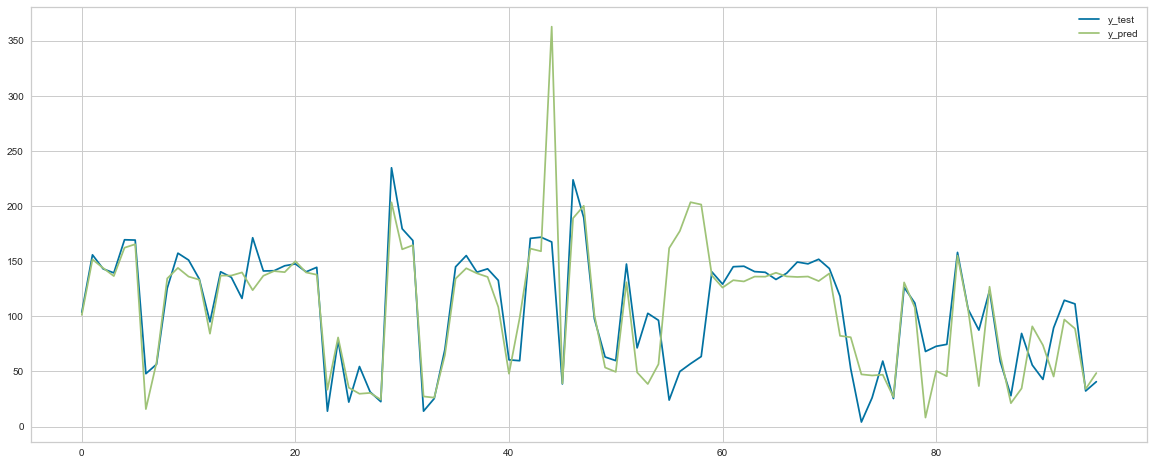

In [386]:
df_final.plot(figsize = (20, 8))
plt.show()